# 2D Porb-e distribution

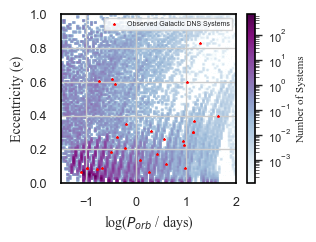

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from matplotlib.colors import LogNorm
import seaborn as sns
import style


# Observed DNS data
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]

csv_files = glob.glob('/Users/ashwathinair/Trials with kick and e/CSV/trial_MM2020_MU2B0.1_Kapil_etal_ussn_vk_3_ecsn1.6533_vk_2_wo4msun/data_*.csv')
assert len(csv_files) > 0, f"Found {len(csv_files)} csv files, is the path correct?"

#MHe_min = 1.0
#MHe_max = 10.0
# Define IMF as a function
def imf(mass, alpha=2.35):#, M_min=MHe_min, M_max=MHe_max):
    return mass**-alpha

def porb_weight(P_orb):
    return 1 / P_orb

all_masses = []
all_P_orb = []
all_e = []

for file in csv_files:
    data = pd.read_csv(file)
    
#     if 'Initial Mass (Msun)' not in data.columns:
#         print(f"File {file} does not contain required column 'Initial Mass (Msun)'. Skipping...")
#         continue

    # Extract initial mass data
    masses = data['initial_star_mass']
    P_orb = data['Porb']
    e = data['e']
   
    
    all_masses.extend(masses)
    all_P_orb.extend(P_orb)
    all_e.extend(e)

# list to numpy array
all_masses = np.array(all_masses)
all_P_orb = np.array(all_P_orb)
all_e = np.array(all_e)

# Calculate IMF weights
imf_weights = imf(all_masses)#, M_min=MHe_min, M_max=MHe_max)
porb_weights = porb_weight(all_P_orb)
#porb_weight = 
# Log-transform orbital periods
log_P_orb = np.log10(all_P_orb)

# Define bins
log_P_bins = np.linspace(-1.5, 2, 90)
e_bins = np.linspace(0, 1, 90)

combined_weights = imf_weights * porb_weights

# computinfg using imf weights

H_weighted, xedges, yedges = np.histogram2d(
    log_P_orb, all_e, bins=[log_P_bins, e_bins], weights=combined_weights)

# Plotting
plt.style.use(style.style1)
sns.set(style="white")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"


fig, ax = plt.subplots(figsize=(3.321, 7/9*3.321))

cax = ax.imshow(H_weighted.T, origin='lower', aspect='auto',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                cmap='Purples', norm=LogNorm())
cax = ax.imshow(H_weighted.T, origin='lower', aspect='auto',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                cmap='BuPu',norm=LogNorm())

#Add color bar
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Number of Systems', fontsize=8, fontname='Times New Roman')


#Adjust major and minor ticks
cbar.ax.tick_params(axis='y', which='major', labelsize=8, length=5, width=1)  # Major ticks
cbar.ax.tick_params(axis='y', which='minor', labelsize=8, length=3, width=0.5)  # Minor ticks

#Overlay observed DNS systems
ax.scatter(np.log10(dns_orbital_periods), dns_eccentricities, color='red', marker='*', s=3,linewidths=0.5, label='Observed Galactic DNS Systems')

# Customize plot

#ax.set_title('Orbital period vs Eccentricity for Simulated Population', fontsize=25, fontname='Times New Roman')
ax.set_xlabel('log($P_{orb}$ / days)', fontsize=10, fontname='Times New Roman')
ax.set_ylabel('Eccentricity (e)', fontsize=10, fontname='Times New Roman')
plt.tick_params(axis='x', labelsize=10)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
ax.legend(fontsize=5)
ax.grid(True, linewidth=1)

DPI = 800

plt.savefig("/Users/ashwathinair/Trials with kick and e/Plots/2D Porb_e_imf_2.35/MM2020_MU2B0.1_Kapil_etal_ussn_vk_3_ecsn1.6533_vk_2_wo4msun.png",dpi=DPI)

plt.show()
outside_range = np.sum((all_masses < 2.9) | (all_masses > 8.0))
print(f"Number of systems outside the valid range: {outside_range}")



# DNS Total mass distribution

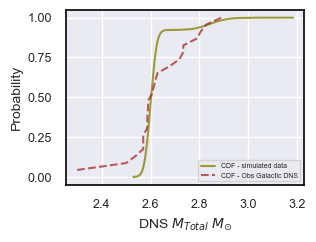

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from latex_table_convert import get_Mt, latex_table_string
#import mplcyberpunk
import seaborn as sns
import style
from matplotlib.ticker import LogLocator, FormatStrFormatter
from matplotlib.ticker import PercentFormatter

#plt.style.use("cyberpunk")

csv_files = glob.glob('/Users/ashwathinair/Trials with kick and e/CSV/MM2020_MU2B0.1_Kapil_etal_ussn_ecsn1.6533/data_*.csv')
#csv_files = glob.glob('/Users/ashwathinair/Downloads/Porb-e for DNS models/CSV data for gw systems with change in mm20/data_*.csv')

def remove_irrelevant_systems(df):
    M_min = 1.1
    M_max = 3.5
    return df.query(f"{M_min} <= `DNS mass` < {M_max}")

all_dns_masses = []
initial_masses = []
eccentricities = []
bin_size = 0.1

for csv_filename in csv_files:
    df = pd.read_csv(csv_filename)
    df = remove_irrelevant_systems(df)
    all_dns_masses.extend(df['DNS mass'].values)
    initial_masses.extend(df['initial_star_mass'].values)
    eccentricities.extend(df['e'].values)
dns_masses = np.array(all_dns_masses)
eccentricities = np.array(eccentricities)
def calculate_fraction_above_threshold(masses, threshold):
    total_systems = len(masses)
    systems_above_threshold = np.sum(masses > threshold)
    fraction = systems_above_threshold / total_systems
    print(f"Fraction of DNS systems with total mass above {threshold} Msun: {fraction:.4f} ({fraction*100:.2f}%)")
    return fraction

# Calculate and print the fraction of DNS systems above 3.0 Msun
fraction_above_3 = calculate_fraction_above_threshold(dns_masses, threshold=3.0)

def plot_cdf(data, weights=None, linestyle=None, color=None, tag="", scale_density=False):
    # Sort data and compute cumulative weights
    sorted_data = np.sort(data)
    if weights is None:
        weights = np.ones_like(data)  # Equal weights if not provided
    else:
        weights = np.array(weights)
    cumulative_weights = np.cumsum(weights[np.argsort(data)])
    cumulative_weights /= cumulative_weights[-1]  # Normalize to get CDF

    # Plot the CDF
    plt.plot(sorted_data, cumulative_weights, label=f'CDF{tag}', linestyle=linestyle, alpha=0.75, color=color)
    plt.xlabel('DNS $M_{Total}$ $M_{\odot}$')
    plt.ylabel('Probability')
    plt.xticks(fontsize = 9)
    plt.yticks(fontsize = 9)
    plt.legend(fontsize = 5)

def get_MHe_weighting(MHe_array):
    MHe_array = np.array(MHe_array)
    def salpeter_imf(MHe):
        return MHe ** -2.35
    weights = salpeter_imf(MHe_array)
    weights /= weights.sum()  # Normalize to probabilities
    return weights

plt.style.use(style.style1)
#plt.style.use("cyberpunk")
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "small"

plt.figure(figsize=(3.321, 7/9*3.321))
plt.cla()

# Plot unweighted CDF
#plot_cdf(dns_masses,
#         linestyle='dashed',
#         tag=" - unweighted")

# Plot weighted CDF
weights = get_MHe_weighting(initial_masses)
plot_cdf(dns_masses,
         weights=weights,
         linestyle='solid',
         color = 'olive',
         tag=" - simulated data ")

# Observed CDF
import sys, os
sys.stdout = open(os.devnull, 'w')  # Suppress get_Mt print statements
observed_dns = get_Mt(latex_table_string)
sys.stdout = sys.__stdout__

plot_cdf(observed_dns,
          linestyle='dashed',
          color = 'brown',
          tag=" - Obs Galactic DNS")

# Format the y-axis as percentages
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
DPI = 800
plt.savefig("/Users/ashwathinair/Trials with kick and e/Plots/DNS_Mt_distribution/MM2020_MU2B0.1_Kapil_etal_ussn_ecsn1.6533.png",dpi=DPI)
# Show the plot
plt.show()


## Eccentricity cdf

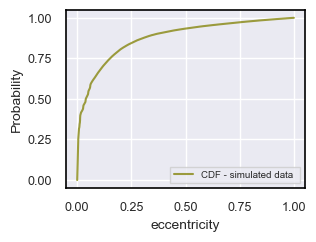

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from latex_table_convert import get_Mt, latex_table_string
#import mplcyberpunk
import seaborn as sns
import style
from matplotlib.ticker import LogLocator, FormatStrFormatter
from matplotlib.ticker import PercentFormatter

#plt.style.use("cyberpunk")

csv_files = glob.glob('/Users/ashwathinair/Trials with kick and e/CSV/MM2020_MU2B0.1_Kapil_etal_ussn_CO1.6_ecsn1.44_vk2/data_*.csv')
#csv_files = glob.glob('/Users/ashwathinair/Downloads/Porb-e for DNS models/CSV data for gw systems with change in mm20/data_*.csv')

def remove_irrelevant_systems(df):
    M_min = 1.1
    M_max = 3.5
    return df.query(f"{M_min} <= `DNS mass` < {M_max}")

all_dns_masses = []
initial_masses = []
eccentricities = []
bin_size = 0.1

for csv_filename in csv_files:
    df = pd.read_csv(csv_filename)
    df = remove_irrelevant_systems(df)
    all_dns_masses.extend(df['DNS mass'].values)
    initial_masses.extend(df['initial_star_mass'].values)
    eccentricities.extend(df['e'].values)
dns_masses = np.array(all_dns_masses)
eccentricities = np.array(eccentricities)

def calculate_fraction_above_threshold(eccentricities, weights, threshold):
    total_weight = np.sum(weights)
    weighted_above_threshold = np.sum(weights[eccentricities < threshold])
    fraction = weighted_above_threshold / total_weight
    print(f"Weighted fraction of DNS systems with eccentricity below {threshold}: {fraction:.4f} ({fraction*100:.2f}%)")
    return fraction


# Calculate and print the fraction of DNS systems above 3.0 Msun

def plot_cdf(data, weights=None, linestyle=None, color=None, tag="", scale_density=False):
    # Sort data and compute cumulative weights
    sorted_data = np.sort(data)
    if weights is None:
        weights = np.ones_like(data)  # Equal weights if not provided
    else:
        weights = np.array(weights)
    cumulative_weights = np.cumsum(weights[np.argsort(data)])
    cumulative_weights /= cumulative_weights[-1]  # Normalize to get CDF

    # Plot the CDF
    plt.plot(sorted_data, cumulative_weights, label=f'CDF{tag}', linestyle=linestyle, alpha=0.75, color=color)
    plt.xlabel('eccentricity')
    plt.ylabel('Probability')
    plt.xticks(fontsize = 9)
    plt.yticks(fontsize = 9)
    plt.legend(fontsize = 7)

def get_MHe_weighting(MHe_array):
    MHe_array = np.array(MHe_array)
    def salpeter_imf(MHe):
        return MHe ** -2.35
    weights = salpeter_imf(MHe_array)
    weights /= weights.sum()  # Normalize to probabilities
    return weights

plt.style.use(style.style1)
#plt.style.use("cyberpunk")
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "small"

plt.figure(figsize=(3.321, 7/9*3.321))
plt.cla()

# Plot unweighted CDF
#plot_cdf(dns_masses,
#         linestyle='dashed',
#         tag=" - unweighted")

# Plot weighted CDF
weights = get_MHe_weighting(initial_masses)
fraction = calculate_fraction_above_threshold(eccentricities, weights, threshold=0.5)

plot_cdf(eccentricities,
         weights=weights,
         linestyle='solid',
         color = 'olive',
         tag=" - simulated data ")

# Observed CDF
# import sys, os
# sys.stdout = open(os.devnull, 'w')  # Suppress get_Mt print statements
# observed_dns = get_Mt(latex_table_string)
# sys.stdout = sys.__stdout__

# plot_cdf(observed_dns,
#          linestyle='dashed',
#          color = 'brown',
#          tag=" - Obs Galactic DNS")

# Format the y-axis as percentages
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
DPI = 800
plt.savefig("/Users/ashwathinair/Trials with kick and e/Plots/Ecc_cdf/MM2020_MU2B0.1_Kapil_etal_ussn_CO1.6_ecsn1.44_vk2.png",dpi=DPI)
# Show the plot
plt.show()
